### Content:
- Load stock prices for all companies (or industry-wise)
- Granger causality (?)
- Incorporate Cointegration from E-G test (optional also add Johanse method as cross check)

Best Link for Explanation: https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html

In [2]:
import pyxdameraulevenshtein

In [3]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import itertools

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset
from src.econometric_utils import *
# from statsmodels.tsa.stattools import grangercausalitytests

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [4]:
ds = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'])
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv')
ds.load()
securities.load()


time: 9.78 s


In [5]:
target_size = ds.get_prices('MSFT').shape[0]
symbols = ds.get_all_prices().symbol.unique()
symbols = [s for s in symbols if ds.get_prices(s).shape[0] == target_size]
caus_values = pd.DataFrame(0.0, index=symbols, columns=symbols)
prices = dict((sym, ds.get_prices(sym)) for sym in symbols)

time: 26.7 s


In [29]:
coint = pd.read_csv('./cointegration-10-to-12.csv', index_col=0)

time: 113 ms


In [156]:
coint.stack().nlargest(5)

PPG  SPG    0.975258
SPG  PPG    0.975258
PPG  WYN    0.966016
WYN  PPG    0.966016
EMN  SE     0.964727
dtype: float64

time: 150 ms


0.9647269773606946
[0.33355915440540573, 0.49391662914739487, 0.3901228816300827, 0.17245496820809664, 0.13132204938882738]


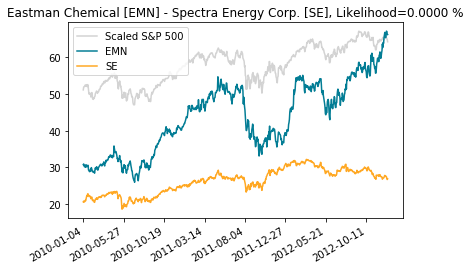

time: 730 ms


In [163]:
inspect_pair(['EMN', 'SE'], 0)
print(get_p_values('EMN', 'SE', maxlag=5))

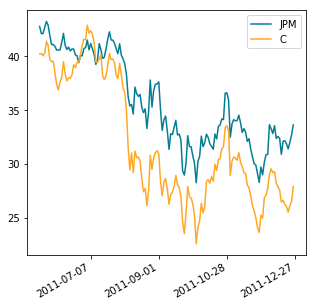

time: 331 ms


In [6]:
colors = ['#037d95', '#ffa823']  # blue green, orange yellow

def plot_company_price(symbols, ax=None):
    p = prices[symbols[0]]
    values = [prices[sym].open.reset_index(drop=True) for sym in symbols]
    values = pd.DataFrame(values).T
    values.columns = symbols
    ax = values.iloc[350:500].plot(ax=ax, color=colors[:len(symbols)], figsize=(5, 5))
    # ax = values.iloc[480:497].plot(color='#037d95')
    ax.set_xticks(ax.get_xticks()[2:-1:2])
    xticklabels = [p.date.iloc[x].date() if x in values.index else '' for x in ax.get_xticks().astype(int)]
    # xticklabels = np.concatenate([[''], [ax.get_xticks()[1:-1]], ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()
    ax.get_figure().savefig('jpm-2011-12-27.pdf')
    return ax

ax = plot_company_price(['JPM', 'C'])

In [142]:
gspc = ds.load_gspc().gspc_open.reset_index(drop=True)
color = ['lightgray', '#037d95', '#ffa823']
def inspect_pair(pair, value, normalize_price=False):
    value = features.loc[pair[0], pair[1]] if value is None else value
    companies = [securities.get_company_name(x) for x in pair]
    if normalize_price:
        opens = [pd.Series(normalize(prices[x].open.reset_index(drop=True))) for x in pair]
    else:
        opens = [prices[x].open.reset_index(drop=True) for x in pair]
    pair_prices = pd.concat([gspc * np.max(opens) / gspc.max(), *opens], axis=1)
    pair_prices.columns = ['Scaled S&P 500'] + pair
    ax = pair_prices.plot(title=f'{companies[0]} [{pair[0]}] - {companies[1]} [{pair[1]}], Likelihood={value:.4f} %', color=color)
    xticklabels = np.concatenate([[''], prices[pair[0]].date.iloc[ax.get_xticks()[1:-1].astype(int)].astype(str), ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()

time: 242 ms


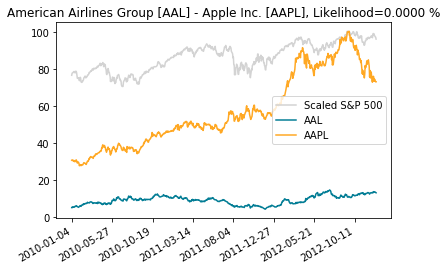

time: 392 ms


In [143]:
inspect_pair(['AAL', 'AAPL'], 0)

In [32]:
def get_p_values(p1, p2, maxlag=100):
    if isinstance(p1, str):
        p1 = prices[p1]['open']
        p2 = prices[p2]['open']
    matrix = np.array([p2, p1]).T
    test_result = grangercausalitytests(matrix, maxlag=maxlag, verbose=False)
    return [lag_test[0]['ssr_ftest'][1] for lag_test in test_result.values()]
    # return [lag_test[0]['ssr_ftest'][1] for lag_test in test_result.values()] + [get_best_cointegration_certainty(p1, p2, debug=False)]

time: 22.8 ms


0.5727690101743163
0.1679715811606215
0.1869678183800137


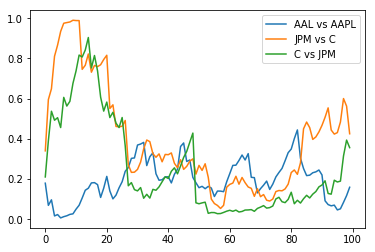

time: 10.2 s


In [7]:
# Cointegration: [JPM, C]
# No Conintegration: [AAL, AAPL] [AGN, AMG]
plt.plot(get_p_values('AAL', 'AAPL'), label='AAL vs AAPL')
plt.plot(get_p_values('JPM', 'C'), label='JPM vs C')
plt.plot(get_p_values('C', 'JPM'), label='C vs JPM')
# plt.plot(get_p_values('AGN', 'AMG'), label='AGN vs AMG')
plt.legend()

In [35]:
caus_values = pd.DataFrame(0.0, index=pd.MultiIndex.from_product([symbols, symbols]), columns=range(5))
for s1, s2 in tqdm(itertools.combinations(symbols, r=2), total=len(caus_values.index)):
    p1 = prices[s1]['open']
    p2 = prices[s2]['open']
    caus_values.loc[s1, s2] = get_p_values(p1, p2, maxlag=5)
    caus_values.loc[s2, s1] = get_p_values(p2, p1, maxlag=5)

# TODO: Combine with coint and cooc
# print('Correlation between GC p-values and Coint p-value:')
# caus_values.corr().loc[5]
# caus_values.to_csv('granger-causality-10-to-12.csv')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



time: 54min 34s


In [504]:
gspc = ds.load_gspc().gspc_open.reset_index(drop=True)
gspc_r = get_daily_rel_change(gspc)

time: 188 ms


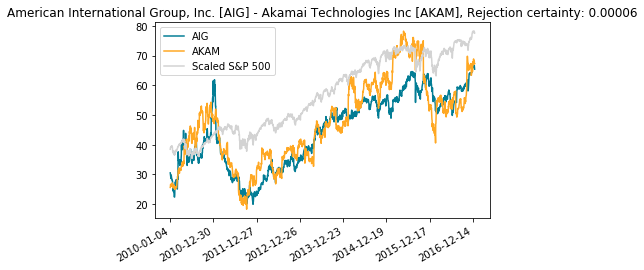

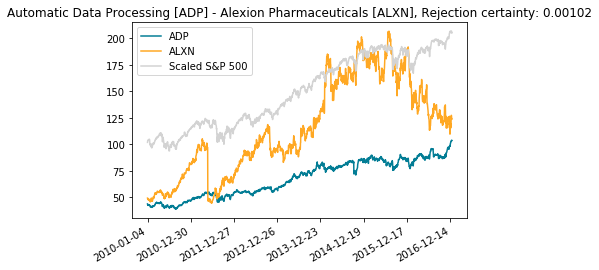

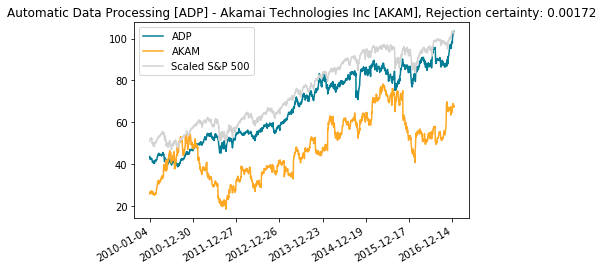

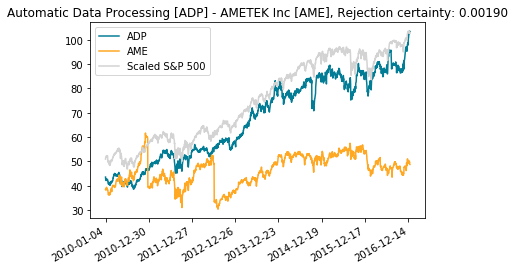

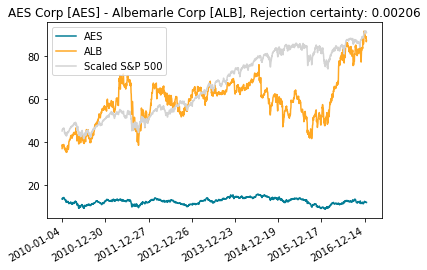

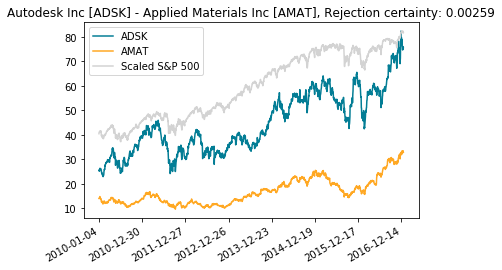

time: 2.02 s


In [293]:
# Source: http://www.gardening.cornell.edu/homegardening/scene638f.html
color = ['lightgray', '#037d95', '#ffa823']  # lightgrey, blue green, orange yellow
# features = pd.read_csv('cointegration.csv', index_col=0)


def inspect_pair(pair, value, normalize_price=False):
    value = features.loc[pair[0], pair[1]] if value is None else value
    companies = [securities.get_company_name(x) for x in pair]
    if normalize_price:
        opens = [pd.Series(normalize(prices[x].open.reset_index(drop=True))) for x in pair]
    else:
        opens = [prices[x].open.reset_index(drop=True) for x in pair]
    pair_prices = pd.concat([gspc * np.max(opens) / gspc.max(), *opens], axis=1)
    pair_prices.columns = ['Scaled S&P 500'] + pair
    ax = pair_prices.plot(title=f'{companies[0]} [{pair[0]}] - {companies[1]} [{pair[1]}], Likelihood={value:.4f} %', color=color)
    xticklabels = np.concatenate([[''], prices[pair[0]].date.iloc[ax.get_xticks()[1:-1].astype(int)].astype(str), ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()

amount = 30
stack = features.iloc[:amount, :amount].stack()
stack = stack[[p[0] < p[1] for p, v in stack.iteritems()]]
# stack = stack[[securities.get_industry(p[0]) == securities.get_industry(p[1]) for p, v in stack.iteritems()]]
for pair, value in stack.nsmallest(6).iteritems():
    inspect_pair(list(pair), value)

### Correlating stock prices

In [ ]:
inspect_pair(['JPM', 'C'])  # Bank
print("Normalize by index")
inspect_pair(['JPM', 'C'], normalize_price=True)
# inspect_pair(['JPM', 'GS'])  # Bank
# inspect_pair(['AET', 'ANTM'])  # Health Insurance
# inspect_pair(['EMR', 'ETN'])  # Energy: https://www.fool.com/investing/general/2013/10/23/can-eaton-earnings-top-emerson-electric-and-abb.aspx

### Look for great jumps

In [584]:
window_size = 14
shift = 30
tech_comps = ['AAPL', 'MSFT', 'GOOGL', 'FB', 'HPQ', 'IBM', 'PYPL', 'QCOM', 'SYMC', 'YHOO']

def show_jump(p, o, jump_idx, shift):
    plt.plot(o[jump_idx-300:jump_idx+301+shift])
    ax = plt.gca()
    xticklabels = np.concatenate([[''], p.date.iloc[ax.get_xticks()[1:-1].astype(int)].astype(str), ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()
    plt.axvline(jump_idx, alpha=0.5)
    plt.axvline(jump_idx+shift, alpha=0.3)
    ax.set_title(f'{p.iloc[0].symbol}:  Low={o[jump_idx]:.2f}; High={o[jump_idx+shift]:.2f}\n({p.date[jump_idx]:%d, %b %Y} - {p.date[jump_idx+shift]:%d, %b %Y})');

for sym in tech_comps:
    p = ds.get_prices(sym).reset_index(drop=True)
#     if str(p.date.min()) != '2010-01-04 00:00:00':
#         print(f"Skip {sym}")
#         continue
    o = pd.Series(moving_average(p.open, window_size)).dropna()
    jump_idx = (o.shift(-shift) - o).abs()[shift:].idxmax()
    # show_jump(p, o, jump_idx, shift)
    # plt.show()
    print(sym, p.date[jump_idx], '-', p.date[jump_idx+shift])

AAPL 2015-01-13 00:00:00 - 2015-02-26 00:00:00
MSFT 2015-09-22 00:00:00 - 2015-11-03 00:00:00
GOOGL 2015-07-01 00:00:00 - 2015-08-13 00:00:00
FB 2015-10-05 00:00:00 - 2015-11-16 00:00:00
HPQ 2011-07-26 00:00:00 - 2011-09-07 00:00:00
IBM 2014-09-19 00:00:00 - 2014-10-31 00:00:00
PYPL 2016-01-22 00:00:00 - 2016-03-07 00:00:00
QCOM 2015-10-27 00:00:00 - 2015-12-09 00:00:00
SYMC 2012-07-18 00:00:00 - 2012-08-29 00:00:00
YHOO 2014-10-13 00:00:00 - 2014-11-24 00:00:00
time: 1.25 s


### For Presentation Slide

In [ ]:
p = prices['JPM']
v = p.open.reset_index(drop=True)
ax = v.iloc[350:500].plot(color='#037d95', figsize=(5, 5))
# ax = v.iloc[480:497].plot(color='#037d95')
ax.set_xticks(ax.get_xticks()[2:-1:2])
print(ax.get_xticks())
xticklabels = [p.date.iloc[x].date() if x in v.index else '' for x in ax.get_xticks().astype(int)]
print(xticklabels)
# xticklabels = np.concatenate([[''], [ax.get_xticks()[1:-1]], ['']])
ax.set_xticklabels(xticklabels)
ax.get_figure().autofmt_xdate()
ax.get_figure().savefig('jpm-2011-12-27.pdf')

### Links Stack
- https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html
- http://cmi.comesa.int/wp-content/uploads/2014/06/Stationarity-and-Cointegration-Analysis.pdf
- https://stats.stackexchange.com/questions/328797/why-do-we-use-vector-autoregressive-models
- https://econometricswithr.wordpress.com/time-series/an-introduction-to-vector-autoregression-var/
- https://ideas.repec.org/a/taf/applec/v38y2006i13p1489-1500.html
- file:///C:/Users/Thomas/Documents/song2017%20-%20A%20better%20understanding%20of%20Granger%20causality%20analysis%20-%20a%20big%20data%20environment.pdf
- https://www.tandfonline.com/doi/abs/10.1080/00949650008811997?src=recsys
- https://www.researchgate.net/post/How_should_I_perform_2-step_co-integration_test_Should_I_input_the_original_data_for_regression_or_should_I_input_1st_order_difference